# Voter Data Analysis

## Overview
As my capstone project for Flatiron School’s Data Science program I built a model to predict how individuals would vote in a presidential election based on data from the 2012, 2016 and 2020 elections. I then used that model to analyze how broad categories of political issues and individual issues themselves influence an individual’s vote. I also examined the accuracy of predictions based on basic demographic information like income, race, education etc. 

## Business Understanding
This type of modeling could be useful in a number of contexts. Most obviously for a campaign interested in focusing their efforts on individuals most likely to vote for them but it could also be useful for political parties and special interest groups who want to better understand their constituents and the public as a whole. 

## Data
My data comes from the American National Election Studies for the years 2012, 2016 and 2020. The ANES is a national survey of voters in the United States, conducted before and after every presidential election. I used a subset of that data curated by the Inter-university Consortium for Political and Social Research. 
The full ANES survey data is publicly available for download from here: https://electionstudies.org/. You do have to make an account to access the data which you can do by clicking the login button in the top right corner of the home page. Once you have completed that process click on the Data Center tab at the top of the home page, then select the data set you would like (For example: 2020 Time Series Study) and then under the download data heading on the next page select the type of file you would like. 
The Inter-university Consortium for Political and Social Research’s data is available here: https://www.icpsr.umich.edu/web/pages/instructors/setups2020/ to individuals with an email address from with one of their member institutions. Once you have made an account with that email address, click on the “Find Data” tab at the top of the page and search for the data set i.e (Voting Behavior: The 2020 Election, Voting Behavior: The 2016 Election, or Voting Behavior: The 2012 Election). The first result will take you to a page where you can download the data.

## Data Preparation
To prepare my data for modeling I first dropped all rows where individuals did not vote or voted for a third party candidate. This left me with 6075 rows to work with. The columns are broken into 16 categories denoted by a letter in front of the question number. For example A01 and R15. Questions in categories A, D and E relate to past political behavior and opinions of current and former politicians. These are obviously strongly correlated with vote preference and are uninteresting in terms of analysis so were dropped. The data is categorical and so needed to be encoded. I used One Hot Encoding to avoid imposing a hierarchy where none should exist. 

In [116]:
# Imports
from sklearn.model_selection import cross_validate, cross_val_score, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string


In [117]:
# Reading in data and displaying first 5 rows
df2020 = pd.read_stata('data/SETUPS2020/SETUPS2020.dta')
df2020.head()

,CASEID,A01,A02,A03,A04,A05,A06,A07,A08,A09,...,R10,R11,R12,R13,R14,R15,R16,R17,R18,WEIGHT
0,200015,0. Did not vote,9. NA,9. NA,9. NA,9. NA,7. Strong Republican,2. Republican party,1. 0 through 24,5. 76 through 100,...,3. Hispanic,4. Bachelor's degree,"7. $125,000 or more",4. Divorced,"1. Yes, living with a partner",1. Heterosexual or straight,3. Have never served on active duty,2. No,4. City,0.611133
1,200022,1. Voted,3. Jo Jorgensen,9. NA,9. NA,9. NA,4. Independent,3. None or 'independent',1. 0 through 24,3. 50,...,4. Asian or Native Hawaiian/other Pacific Isla...,"3. Some post-high school, no bachelor's degree","4. $50,000 to $74,999",1. Married: spouse present,9. NA,1. Heterosexual or straight,3. Have never served on active duty,2. No,3. Suburb,1.209783
2,200039,1. Voted,1. Joe Biden,1. Voted for the Democratic candidate,1. Voted for the Democratic candidate,9. NA,3. Independent-Democrat,9. NA,4. 51 through 75,1. 0 through 24,...,"1. White, non-Hispanic",2. High school credential,"6. $100,000 to $124,999",1. Married: spouse present,9. NA,1. Heterosexual or straight,3. Have never served on active duty,2. No,3. Suburb,0.823936
3,200046,1. Voted,1. Joe Biden,2. Voted for the Republican candidate,9. NA,9. NA,6. Not very strong Republican,2. Republican party,3. 50,4. 51 through 75,...,4. Asian or Native Hawaiian/other Pacific Isla...,"3. Some post-high school, no bachelor's degree","3. $35,000 to $49,999",1. Married: spouse present,9. NA,1. Heterosexual or straight,3. Have never served on active duty,2. No,2. Small town,0.512837
4,200053,1. Voted,2. Donald Trump,2. Voted for the Republican candidate,2. Voted for the Republican candidate,9. NA,4. Independent,3. None or 'independent',1. 0 through 24,4. 51 through 75,...,5. Native American/Alaska Native or other race...,5. Graduate degree,"7. $125,000 or more",3. Widowed,"2. No, not living with a partner",1. Heterosexual or straight,3. Have never served on active duty,2. No,4. City,0.856575


In [118]:
df2020.drop(['CASEID','WEIGHT'], axis=1, inplace=True)

In [119]:
# Taking a look at the first column which askes if the respondent voted
df2020['A01'].value_counts()

1. Voted           6407
0. Did not vote    1040
9. NA                 6
Name: A01, dtype: int64

In [120]:
# The second question asks who the respondent voted for
df2020['A02'].value_counts()

1. Joe Biden                    3509
2. Donald Trump                 2566
9. NA                           1199
5. Other candidate {SPECIFY}      84
3. Jo Jorgensen                   71
4. Howie Hawkins                  24
Name: A02, dtype: int64

This analysis is limited to individuals who voted in 2020 for one of the two major candidates so next I kept only those rows.

In [121]:
# Subsetting data to keep only rows where the respondent voted for Donald Trump or Joe Biden
df2020 = df2020.loc[(df2020['A01'] == '1. Voted') & ((df2020['A02'] == '1. Joe Biden') | (df2020['A02'] == '2. Donald Trump'))]

The data set I'm using has an accompaning codebook that gives more information on each column. It can be found in the data folder of my github repository. After looking over the survey questions I decided to drop all questions in the A, D, and E categories. These questions relate to past political behavior and opinions of current and former politicians and would make the modeling task too simple. Before doing that I need to get the target which is stored in column A02

In [122]:
# Getting target
y = df2020['A02']
X = df2020.drop(['A02'], axis=1, errors = "ignore")

I wrote a function to get the question categories for my dataset. This will help with subsetting the data later

In [123]:
# This function returns a dictionary where the key is the question category and the associated value is a list of 
# Columns in that category
def get_columns(df):
    # Creating empyt  dictionary
    dictionary = {}
    # Looping through potential categories 
    alphabet = list(string.ascii_uppercase[0:26])
    for char in alphabet:
        # Creating dictionary entry
        dictionary[char] = []
        for num in list(range(df.shape[1])):
            if df.columns[num].startswith(char):
                # Populating dictionary entry
                dictionary[char].append(df.columns[num])            
        temp = dictionary.pop(char)
        # Removing keys where the value is empty
        if temp != []:
            dictionary[char] = temp
    # Returning dictionary
    return dictionary

In [124]:
# Getting question categories for the 2020 dataset
_2020_dictionary = get_columns(df2020)

In [125]:
# Dropping question categories
df2020.drop(_2020_dictionary['A'], axis=1, inplace=True, errors = "ignore")
df2020.drop(_2020_dictionary['D'], axis=1, inplace=True)
df2020.drop(_2020_dictionary['E'], axis=1, inplace=True)

In [126]:
_2020_dictionary.pop('A')
_2020_dictionary.pop('D')
_2020_dictionary.pop('E');

In [188]:
categorical_columns = list(df2020.columns)

# Train Test Split

In [128]:
# Preforming train/test split
X = X[categorical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Dummy Model

Using the uniform strategy for the dumy model should result in a roughly 50/50 split between our two choices which is what we see. This will serve as our baseline to compare the following models against

In [129]:
# Dummy model to use as baseline
dummy_clf = DummyClassifier(strategy = "uniform")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.5042791310072416

Now that we have that as a baseline we can begin the modeling process. We will start with a decision tree.

# Decision Tree

In [130]:
# Setting up one hot encoder to use with our categorical data
categorical_processing = OneHotEncoder(handle_unknown='ignore')

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_processing, categorical_columns),
    ],
    verbose_feature_names_out=False,
)

# Setting up pipeline steps
tree_pipe = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", DecisionTreeClassifier(random_state=42)),
    ]
)
# Fitting pipeline to the training data
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [131]:
# Getting predictions
y_pred = tree_pipe.predict(X_train)
# Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

# Getting cross validation score 
print(f"CV accuracy: {cross_val_score(tree_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  1.0
CV accuracy: 0.9242730178905003


As a starting point that is a good score. Lets see if we can improve on it by tuning the hyper parameters using GridSearchCV  which tries every combonation of parameters looking for the best results

# Decision Tree Second Iteration 

In [17]:
# # Setting up parameter grid
# param_grid = {'classifier__criterion': ['gini', 'entropy', 'log_loss'],               
#               'classifier__max_depth': [2, 4, 6, 8, 10, 12]
#              }
# # Executing gridsearch
# gridsearch = GridSearchCV(estimator=tree_pipe,
#                           param_grid=param_grid,
#                           scoring='accuracy',
#                           cv=5,
#                           n_jobs = 3
#                          )
# # Fit the training data
# gridsearch.fit(X_train, y_train)

In [18]:
# # Print accuracy score for the best estimator and the best parameters 
# print(f'Best estimator score: ' + '{:.4%}'.format(gridsearch.score(X_train, y_train)))
# print(f'Gridsearch best params: ')
# print(gridsearch.best_params_)

### Results
Gridsearch score:  0.979367866549605

Gridsearch best params: 
- 'classifier__criterion': 'gini'
- 'classifier__max_depth': 8

In [19]:
# Updating the parameters in the pipeline
tree_pipe.set_params(classifier__criterion = 'gini',
                     classifier__max_depth = 8,
                    )
# Refitting pipeline
tree_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=8, random_state=42))])

In [20]:
# # Updating the parameters in the pipeline
# tree_pipe.set_params(classifier__criterion = gridsearch.best_params_['classifier__criterion'],
#                      classifier__max_depth = gridsearch.best_params_['classifier__max_depth'],
#                     )
# # Refitting pipeline
# tree_pipe.fit(X_train, y_train)

In [21]:
# Getting predictions from pipeline
y_pred = tree_pipe.predict(X_train)

# Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

# Getting cross validation score for training data 
print(f"CV accuracy: {cross_val_score(tree_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  0.979367866549605
CV accuracy: 0.9381018063820363


There is some improvement there but the tree is still somewhat over fit. Let’s take a look at the feature importance to get a better sense of what is going on.

# Feature Importance

In [22]:
# This function gets feature importances out of the pipeline. Single features are broken up into multiple columns because of 
# the encoding. This aggregates the importances by feature so high cardinality features are not discounted. 

def get_feature_importances(pipe):
    # Getting feature names
    feature_names = pipe[:-1].get_feature_names_out()
    # Creating a series with the feature names and their importances 
    feature_importances = pd.Series(pipe[-1].feature_importances_, index=feature_names).sort_values(ascending=True)
    # Creating a pandas datafram with the feature importances
    importances = feature_importances.to_frame(name = 'importance').reset_index().rename(columns={"index": "feature"})
    # Slicing the feature names stored in 'feature' to the first three letter which is the original feature name
    importances['feature'] = importances['feature'].str.slice(0, 3)
    # Grouping and summing the features
    importances = importances.groupby('feature').sum()
    # Returning a datafram with the feature importances
    return importances

In [23]:
# Getting top 10 feature importances for the Tree
tree_importances = get_feature_importances(tree_pipe)
tree_importances.nlargest(10, columns= 'importance')

,importance
feature,
P28,0.661556
H05,0.109602
K11,0.039734
H04,0.030105
P27,0.018483
H02,0.017921
F26,0.014479
C02,0.013043
K09,0.011524


In [24]:
# getting 10 smallest feature importances
tree_importances.nsmallest(10, columns= 'importance')

,importance
feature,
B01,0.0
B02,0.0
B03,0.0
B04,0.0
B05,0.0
B06,0.0
B07,0.0
B08,0.0
B09,0.0


In [25]:
# Summing 100 smallest feature importances
tree_importances.nsmallest(100, columns= 'importance').sum()

importance    0.0
dtype: float64

The sum of the 100 least important features is zero so the tree is not taking those into account. Next we will try a random forest which creates a number of decision trees each using a different random subset of features. This will allow it to use a broader selection of the data and hopefully get better results. 

# Random Forest

In [26]:
# Setting up one hot encoder to use with our categorical data
categorical_processing = OneHotEncoder(handle_unknown='ignore')

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_processing, categorical_columns),
    ],
    verbose_feature_names_out=False,
)

# Setting up pipeline steps
forest_pipe = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Fitting pipeline to the training data
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [27]:
# Getting predictions from pipeline using training data
y_pred = forest_pipe.predict(X_train)

# Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

# Getting cross validation score for training data 
print(f"CV accuracy: {cross_val_score(forest_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  1.0
CV accuracy: 0.9613702890596414


That’s a good score for an untuned model but it is over fit. I will try to address that using RandomizedSearchCV and GridSearchCV to tune the hyper parameters.

# RandomizedSearchCV

In [28]:
# Setting up the parameters for RandomizedSearchCV to test
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Creating random grid
random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}

In [29]:
# # setting up RandomizedSearchCV 
# forest_random = RandomizedSearchCV(estimator = forest_pipe,
#                                    param_distributions = random_grid,
#                                    n_iter = 100,
#                                    cv = 3,
#                                    verbose=2,
#                                    random_state=42,
#                                    n_jobs = -1
#                                   )
# # Fiting random search model
# forest_random.fit(X_train, y_train)

In [30]:
# #checking best parameters
# forest_random.best_params_

### Results
- 'classifier__n_estimators': 400
- 'classifier__min_samples_split': 5
- 'classifier__min_samples_leaf': 2
- 'classifier__max_depth': 90
- 'classifier__bootstrap': False
 

# GridSearchCV

Based on the results from our randomized search I constructed this parameter grid to feed into GridSearchCV.

In [31]:
# # Setting up parameter grid
# param_grid = {'classifier__n_estimators': [200, 300, 400],
#               'classifier__criterion': ['gini', 'entropy', 'log_loss'],               
#               'classifier__max_depth': [70, 80, 90],
#               'classifier__min_samples_split': [4, 5, 6],
#               'classifier__min_samples_leaf': [2, 3, 4],
#               'classifier__bootstrap': [False, True]
#              }
# # Executing gridsearch
# gridsearch = GridSearchCV(estimator=forest_pipe,
#                           param_grid=param_grid,
#                           scoring='accuracy',
#                           cv=5,
#                           n_jobs = 3
#                          )
# # Fit the training data
# gridsearch.fit(X_train, y_train)

In [32]:
# # Print the accuracy on train set
# print(f'Best estimator score: ' + '{:.4%}'.format(gridsearch.score(X_train, y_train)))
# print(f'Gridsearch best params: ')
# print(gridsearch.best_params_)

### Results

Best estimator score: 99.2098%

Gridsearch best params: 
- 'classifier__bootstrap': True 
- 'classifier__criterion': 'gini' 
- 'classifier__max_depth': 70 
- 'classifier__min_samples_leaf': 3 
- 'classifier__min_samples_split': 4 
- 'classifier__n_estimators': 300

In [33]:
# Updating the parameters in the pipeline
forest_pipe.set_params(classifier__bootstrap = True,
                       classifier__criterion = 'gini',
                       classifier__max_depth = 70,
                       classifier__min_samples_leaf = 3,
                       classifier__min_samples_split = 4,
                       classifier__n_estimators = 300,
                      )
# Refitting pipeline
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(max_depth=70, min_samples_leaf=3,
                                        min_samples_split=4, n_estimators=300,
                                        random_state=42))])

In [34]:
# # Updating the parameters in the pipeline
# forest_pipe.set_params(classifier__n_estimators = gridsearch.best_params_['classifier__n_estimators'],
#                        classifier__criterion = gridsearch.best_params_['classifier__criterion'],
#                        classifier__max_depth = gridsearch.best_params_['classifier__max_depth'],
#                        classifier__min_samples_leaf = gridsearch.best_params_['classifier__min_samples_leaf'],
#                        classifier__min_samples_split = gridsearch.best_params_['classifier__min_samples_split'],
#                        classifier__bootstrap = gridsearch.best_params_['classifier__bootstrap'],
#                       )
# # Refitting pipeline
# forest_pipe.fit(X_train, y_train)

In [35]:
#Getting predictions from pipeline using training data
y_pred = forest_pipe.predict(X_train)

#Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

#getting cross validation score for training data 
print(f"CV accuracy: {cross_val_score(forest_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  0.9920983318700615
CV accuracy: 0.966198942746548


Training data prediction accuracy:  0.9920983318700615

CV accuracy: 0.966198942746548

Slight improvement in both directions but the model is still clearly over fit. The RandomizedSearchCV suggested that the model preformed best with a max depth of 90 which is high. We are worried about overfitting our model so we can try to prune our tree by decreasing the max depth

# Hyperparameter Tuning Second Iteration

In [36]:
# # Setting up parameter grid
# param_grid = {'classifier__n_estimators': [50, 100, 150, 200],
#               'classifier__criterion': ['gini', 'entropy', 'log_loss'],               
#               'classifier__max_depth': [4, 6, 8, 10, 12, 14],
#               'classifier__bootstrap': [True, False]
#              }
# # Executing gridsearch
# gridsearch = GridSearchCV(estimator=forest_pipe,
#                           param_grid=param_grid,
#                           scoring='accuracy',
#                           cv=5,
#                           n_jobs = 3
#                          )
# # Fit the training data
# gridsearch.fit(X_train, y_train)
# # Print the accuracy on test set

In [37]:
# # Print the accuracy on train set
# print(f'Best estimator score: ' + '{:.4%}'.format(gridsearch.score(X_train, y_train)))
# print(f'Gridsearch best params: ')
# print(gridsearch.best_params_)

### Results

Best estimator score: 99.1659%

Gridsearch best params: 
- 'classifier__bootstrap': True
- 'classifier__criterion': gini
- 'classifier__max_depth': 14
- 'classifier__n_estimators': 150

In [38]:
# Updating the parameters in the pipeline
forest_pipe.set_params(classifier__bootstrap = True,
                       classifier__criterion = 'gini',
                       classifier__max_depth = 14,
                       classifier__n_estimators = 150,
                      )
# Refitting pipeline
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(max_depth=14, min_samples_leaf=3,
                                        min_samples_split=4, n_estimators=150,
                                        random_state=42))])

In [39]:
# # Updating the parameters in the pipeline
# forest_pipe.set_params(classifier__bootstrap = gridsearch.best_params_['classifier__bootstrap'],
#                        classifier__criterion = gridsearch.best_params_['classifier__criterion'],
#                        classifier__max_depth = gridsearch.best_params_['classifier__max_depth'],
#                        classifier__n_estimators = gridsearch.best_params_['classifier__n_estimators'],
#                       )
# # Refitting pipeline
# forest_pipe.fit(X_train, y_train)

In [40]:
#Getting predictions from pipeline using training data
y_pred = forest_pipe.predict(X_train)

#Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

#getting cross validation score for training data 
print(f"CV accuracy: {cross_val_score(forest_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  0.9916593503072871
CV accuracy: 0.9664187224372677


Almost no change with those scores. min_samples_split and min_samples_leaf can help prevent overfitting so I try to tune those next.

# Hyperparameter Tuning Third Iteration

In [41]:
# # Setting up parameter grid
# param_grid = {'classifier__n_estimators': [125, 150, 175],              
#               'classifier__max_depth': [12, 14, 16],
#               'classifier__min_samples_split': [4, 6, 8, 10],
#               'classifier__min_samples_leaf': [3, 4, 5, 6],
#              }
# # Executing gridsearch
# gridsearch = GridSearchCV(estimator=forest_pipe,
#                           param_grid=param_grid,
#                           scoring='accuracy',
#                           cv=5,
#                           n_jobs = 3
#                          )
# # Fit the training data
# gridsearch.fit(X_train, y_train)

In [42]:
# # Print the accuracy on train set
# print(f'Best estimator score: ' + '{:.4%}'.format(gridsearch.score(X_train, y_train)))
# print(f'Gridsearch best params: ')
# print(gridsearch.best_params_)

### Results

Best estimator score: 99.1659%

Gridsearch best params:

- 'classifier__max_depth': 14,
- 'classifier__min_samples_leaf': 3,
- 'classifier__min_samples_split': 4,
- 'classifier__n_estimators': 150

In [43]:
# Updating the parameters in the pipeline
forest_pipe.set_params(classifier__max_depth = 14,
                       classifier__min_samples_leaf = 3,
                       classifier__min_samples_split = 4,
                       classifier__n_estimators = 150,
                      )
# Refitting pipeline
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 RandomForestClassifier(max_depth=14, min_samples_leaf=3,
                                        min_samples_split=4, n_estimators=150,
                                        random_state=42))])

In [44]:
# # Updating the parameters in the pipeline
# forest_pipe.set_params(classifier__max_depth = gridsearch.best_params_['classifier__max_depth'],
#                        classifier__min_samples_leaf = gridsearch.best_params_['classifier__min_samples_leaf'],
#                        classifier__min_samples_split = gridsearch.best_params_['classifier__min_samples_split'],
#                        classifier__n_estimators = gridsearch.best_params_['classifier__n_estimators'],
#                       )
# # Refitting pipeline
# forest_pipe.fit(X_train, y_train)

In [45]:
#Getting predictions from pipeline using training data
y_pred = forest_pipe.predict(X_train)

#Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

#getting cross validation score for training data 
print(f"CV accuracy: {cross_val_score(forest_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  0.9916593503072871
CV accuracy: 0.9664187224372677


This iteration resulted in no change from the previous iteration so parameter tuning has gotten me as far as it can. Next I will try incorporating dimensionality reduction using TruncatedSVD.

# TruncatedSVD

In [46]:
# Setting up pipeline steps
forest_pipe_SVD = Pipeline(
    [
        ("preprocess", preprocessing),
        ("SVD", TruncatedSVD(n_components = 200)),
        ("classifier", RandomForestClassifier(max_depth = 12,
                                              n_estimators = 200,
                                              min_samples_split = 5,
                                              min_samples_leaf = 4,
                                              bootstrap = True,
                                              
                                             )
        )
    ]
)
# Fitting pipeline to the training data
forest_pipe_SVD.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('SVD', TruncatedSVD(n_components=200)),
                ('classifier',
                 RandomForestClassifier(max_depth=12, min_samples_leaf=4,
                                        min_samples_split=5,
                                        n_estimators=200))])

In [47]:
# # Setting up parameter grid
# param_grid = {'classifier__n_estimators': [175, 200, 225],
#               'classifier__max_depth': [8, 10, 12],
#               'SVD__n_components' : [10, 100, 200, 300, 1000]
#              }
# # Executing gridsearch
# gridsearch = GridSearchCV(estimator=forest_pipe_SVD, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs = 3)
# # Fit the training data
# gridsearch.fit(X_train, y_train)

In [48]:
# # Print the accuracy on train set
# print(f'Best estimator score: ' + '{:.4%}'.format(gridsearch.score(X_train, y_train)))
# print(f'Gridsearch best params: ')
# print(gridsearch.best_params_)

### Results 

- 'SVD__n_components': 10
- 'classifier__max_depth': 10
- 'classifier__n_estimators': 200

In [49]:
# Updating the parameters in the pipeline
forest_pipe_SVD.set_params(SVD__n_components = 10,
                           classifier__max_depth = 10,
                           classifier__n_estimators = 200
                          )
# Refitting pipeline
forest_pipe_SVD.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('SVD', TruncatedSVD(n_components=10)),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=4,
                                        min_samples_split=5,
                                        n_estimators=200))])

In [50]:
# # Updating the parameters in the pipeline
# forest_pipe_SVD.set_params(SVD__n_components = gridsearch.best_params_['SVD__n_components'],
#                            classifier__max_depth = gridsearch.best_params_['classifier__max_depth'],
#                            classifier__n_estimators = gridsearch.best_params_['classifier__n_estimators']
#                           )
# # Refitting pipeline
# forest_pipe_SVD.fit(X_train, y_train)

In [51]:
#Getting predictions from pipeline using training data
y_pred = forest_pipe_SVD.predict(X_train)

#Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

#getting cross validation score for training data 
print(f"CV accuracy: {cross_val_score(forest_pipe_SVD, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  0.9749780509218613
CV accuracy: 0.9552246422862865


The scores actually got slightly worse. XGBoost is another tree based model that often preforms better than random forests so I will try that next.

# XGBoost

In [134]:
# Setting up pipeline steps
XGBoost_pipe = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", XGBClassifier(random_state=42))
    ]
)
# Fitting pipeline to the training data
XGBoost_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBCla...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [53]:
# #Getting predictions from pipeline using training data
# y_pred = XGBoost_pipe.predict(X_train)
# dd
# #Checking accuracy of predictions
# print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

# #getting cross validation score for training data 
# print(f"CV accuracy: {cross_val_score(XGBoost_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

In [54]:
# param_grid = {'classifier__learning_rate': [0.1, 0.2, 0.3],
#               'classifier__max_depth': [2, 6, 8],
#               'classifier__min_child_weight': [1, 2],
#               'classifier__subsample': [0.5, 0.7],
#               'classifier__n_estimators': [50, 100, 150],
#              }
# # Executing gridsearch
# gridsearch = GridSearchCV(estimator=XGBoost_pipe, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs = 3)
# # Fit the training data
# gridsearch.fit(X_train, y_train)

In [55]:
# # Print the accuracy on train set
# print(f'Best estimator score: ' + '{:.4%}'.format(gridsearch.score(X_train, y_train)))
# print(f'Gridsearch best params: ')
# print(gridsearch.best_params_)

Best estimator score: 98.1782%

Gridsearch best params: 

- 'classifier__learning_rate': 0.1,
- 'classifier__max_depth': 2,
- 'classifier__min_child_weight': 1,
- 'classifier__n_estimators': 150,
- 'classifier__subsample': 0.5

In [135]:
XGBoost_pipe.set_params(classifier__learning_rate = 0.1,
                        classifier__max_depth = 2,
                        classifier__min_child_weight = 1,
                        classifier__subsample = .5,
                        classifier__n_estimators = 150)
XGBoost_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBCla...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.5, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [57]:
# XGBoost_pipe.set_params(classifier__learning_rate = gridsearch.best_params_['classifier__learning_rate'],
#                         classifier__max_depth = gridsearch.best_params_['classifier__max_depth'],
#                         classifier__min_child_weight = gridsearch.best_params_['classifier__min_child_weight'],
#                         classifier__subsample = gridsearch.best_params_['classifier__subsample'],
#                         classifier__n_estimators = gridsearch.best_params_['classifier__n_estimators'])
# # Refitting pipeline
# XGBoost_pipe.fit(X_train, y_train)

In [58]:
#Getting predictions from pipeline using training data
y_pred = XGBoost_pipe.predict(X_train)

#Checking accuracy of predictions
print(f"Training data prediction accuracy: ", accuracy_score(y_train, y_pred))

#getting cross validation score for training data 
print(f"CV accuracy: {cross_val_score(XGBoost_pipe, X_train, y_train, cv=5, scoring = 'accuracy').mean()}")

Training data prediction accuracy:  0.9817822651448639
CV accuracy: 0.9664184817147149


The improvements with the XGBoost model are slight but it is less over fit and has a higher cross validation score so it is the model I will go with.

In [59]:
#Getting predictions from pipeline using testing data
y_pred = XGBoost_pipe.predict(X_test)

#Checking accuracy of predictions
print(f"Testing data accuracy score: ", accuracy_score(y_test, y_pred))

Testing data accuracy score:  0.9684002633311389


The final testing accuracy score is quite good and shows how predictable voting behavior can be

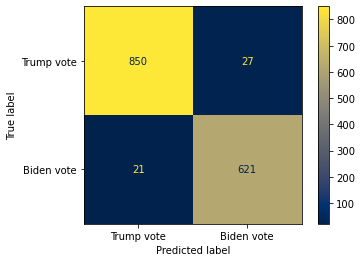

In [60]:
#Creating confusion matrix
cf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cf, display_labels=['Trump vote', 'Biden vote']).plot(cmap = plt.cm.cividis)

# Categorical Analysis

Now that I have a functional model that can predict how an individual will vote based on the whole dataset, I will analyze how well the model preforms when it only has access to a subset of the data. 

In [145]:
# Getting column dictionary for X_train
X_train_dict = get_columns(X_train)
# Setting up scoring dictionary
score_dict = {}

In [242]:
# Looping through the data by category
for key in X_train_dict:
    # Getting columns in the category
    columns = X_train_dict[key]
    # Subsetting the data
    X_train_subset = X_train[columns]
    # Updating the pipeling
    XGBoost_pipe.set_params(preprocess__transformers = [("cat", categorical_processing, columns)])
    # Refitting the model
    XGBoost_pipe.fit(X_train_subset, y_train)
    # Getting the cross validation score
    score_dict[key] = {'cross validation score' : cross_val_score(XGBoost_pipe, 
                                                                          X_train_subset, 
                                                                          y_train, 
                                                                          cv=5, 
                                                                          scoring = 'accuracy').mean()}

In [181]:
# Creating a dictionary to update the category labels
Catagory_labels = {'B' : 'Political Engagement',
                   'C' : 'Media Trust & Consumption',
                   'F' : 'Economy',
                   'G' : 'Direction of Country',
                   'H' : 'Health Care & Policy',
                   'J' : 'Federal Spending',
                   'K' : 'Abortion, Guns, Imigration',
                   'L' : 'Womens and Gender Issues',
                   'M' : 'Race, Diversity & Religious Minorities',
                   'N' : 'Security & Foreign Policy',
                   'P' : 'Trust in Government',
                   'Q' : 'LGBTQ Rights',
                   'R' : 'Demographics'}

In [244]:
# Creating a data frame with updated labels 
score_df = pd.DataFrame.from_dict(score_dict, orient = 'index')
score_df.rename(index = Catagory_labels,inplace=True)
score_df

,cross validation score
Political Engagement,0.606675
Media Trust & Consumption,0.814310
Economy,0.931521
Direction of Country,0.827479
Health Care & Policy,0.943809
Federal Spending,0.916156
"Abortion, Guns, Imigration",0.933058
Womens and Gender Issues,0.790387
"Race, Diversity & Religious Minorities",0.902764
Security & Foreign Policy,0.856455


When looking at the accurate scores for individual categories a few things jump out. Political Engagement has the lowest score which is not particularly surprising because with the country being so narrowly divided, both parties have similar levels of political engagement. The next lowest score is for the Demographics category. This is unfortunate this information is often available at the state or county level so being able to predict how a state or county will vote based on demographics alone would be useful. However the predictions using this data alone are still fairly accurate at 76.4% 

Looking at the most accurate categories, the Trust in Government and Health Care & Policy categories have the highest score with both being above 94.5%. This tracks with what we know American Politics at the moment. Democrats and Republicans don’t agree on much when it comes to health care policy. For example, a study from 2020 by a team from the Harvard T.H. Chan School of Public Health found that three quarters of democrats would like the federal government to ensure that all citizens have health insurance. In contrast, 79% of Republicans preferred a healthcare system that relies on private insurance. (https://jamanetwork.com/journals/jama/fullarticle/2777394) 

The reliability of the Trust in Government category when it comes to predicting ones vote is a bit more troubling. It has long been the case that trust in government declines when an individual’s preferred party is out of power in Washington as one can see in this analysis from Pew: https://www.pewresearch.org/politics/2023/09/19/public-trust-in-government-1958-2023/. However, as we saw following the 2020 election a lack of trust in institutions can quickly turn violent and deadly. The fact that this lack of trust is concentrated on one side of the political spectrum makes that an even more dangerous possibility.   

In [207]:
# Setting up new pipeline 
# Preprocessing steps
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_processing, categorical_columns),
    ],
    verbose_feature_names_out=False,
)

# Setting up pipeline
XGBoost_pipe = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", XGBClassifier(random_state=42,
                                     learning_rate = 0.1,
                                     max_depth = 2,
                                     min_child_weight = 1,
                                     subsample = .5,
                                     n_estimators = 150
                                    )
        )
    ]
)

# Fitting pipeline to the training data
XGBoost_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['B01', 'B02', 'B03', 'B04',
                                                   'B05', 'B06', 'B07', 'B08',
                                                   'B09', 'B10', 'B11', 'B12',
                                                   'B13', 'B14', 'B15', 'B16',
                                                   'B17', 'B18', 'B19', 'B20',
                                                   'B21', 'B22', 'B23', 'C01',
                                                   'C02', 'C03', 'C04', 'C05',
                                                   'C06', 'C07', ...])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBCla...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=0.5, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [202]:
# getting individual feature importances
XGBoost_importances = get_feature_importances(XGBoost_pipe)
XGBoost_importances.nlargest(10, columns= 'importance')

,importance
feature,
P28,0.230252
H05,0.114018
P29,0.109391
F26,0.036291
K09,0.033216
P27,0.032782
N01,0.027380
G01,0.022928
M12,0.021016


When looking at the most important features there are a couple that aren’t surprising. Question P28 asks if the respondent favors the House of Representatives decision to impeach Donald Trump in 2019 and P29 asks if the respondent favors the Senates decision not to convict. Similarly H05 asks if the COVID-19 response was adequate. These were obviously major issues in the 2020 election.

In [232]:
# modeling with a single column
X_train_subset = X_train['H05']
# Updating pipeline
XGBoost_pipe.set_params(preprocess__transformers = [("cat", categorical_processing, _10_most_important_features)])
# Refitting pipeline
XGBoost_pipe.fit(X_train_subset, y_train)
# getting new predictions
y_pred = XGBoost_pipe.predict(X_train_subset)
print(f'cross validation score' , cross_val_score(XGBoost_pipe,
                                           X_train_subset, 
                                           y_train, 
                                           cv=5, 
                                           scoring = 'accuracy').mean())

cross validation score 0.8711571051668688


Something that is interesting is that the model can predict with 87.1% accuracy who the respondent would vote for based on their opinion of the federal government's response to COVID-19. Taking this just a bit further the model loses very little in terms of accuracy as I restrict the features it has access to. Below I've given it features ranked 11 through 20 and 21 through 30 

In [238]:
# Getting features 11 through 20 ranked by importance
next_10_most_important_features = list(XGBoost_importances.nlargest(20, columns= 'importance').index)[10:20]

In [239]:
# modeling with a single column
X_train_subset = X_train[next_10_most_important_features]
# Updating pipeline
XGBoost_pipe.set_params(preprocess__transformers = [("cat", categorical_processing, next_10_most_important_features)])
# Refitting pipeline
XGBoost_pipe.fit(X_train_subset, y_train)
# getting new predictions
y_pred = XGBoost_pipe.predict(X_train_subset)
print(f'cross validation score' , cross_val_score(XGBoost_pipe,
                                           X_train_subset, 
                                           y_train, 
                                           cv=5, 
                                           scoring = 'accuracy').mean())

cross validation score 0.9563230592947791


In [240]:
# Getting features 21 through 30 ranked by importance
next_10_most_important_features = list(XGBoost_importances.nlargest(30, columns= 'importance').index)[20:30]

In [241]:
# modeling with a single column
X_train_subset = X_train[next_10_most_important_features]
# Updating pipeline
XGBoost_pipe.set_params(preprocess__transformers = [("cat", categorical_processing, next_10_most_important_features)])
# Refitting pipeline
XGBoost_pipe.fit(X_train_subset, y_train)
# getting new predictions
y_pred = XGBoost_pipe.predict(X_train_subset)
print(f'cross validation score' , cross_val_score(XGBoost_pipe,
                                           X_train_subset, 
                                           y_train, 
                                           cv=5, 
                                           scoring = 'accuracy').mean())

cross validation score 0.9201053883336222
features:  ['M05', 'H08', 'J08', 'C02', 'P08', 'M07', 'N07', 'P04', 'K08', 'M17']


Even with these less politically charged questions the model still has a very good idea how an individual will vote. For example, one of the columns the model had access to in the final run asked "how important should science be for decisions about COVID-19?" another asked "How much is Iran a threat to the United States?" These are not inherently political questions and in the U.S. they did not used to be politically relevant. However, in the era of hyper polarization, they can accurately predict how an individual will vote